In [1]:
# import libraries
import requests
import json
import time
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# matlab aesthetics
matlab_colors = ['#0072BD', '#D95319', '#EDB120', 
                 '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from importlib import reload # Reload the strava_auth module to get the latest changes
from strava_auth import get_access_token

# get access token
access_token = get_access_token()
url = 'https://www.strava.com/api/v3/athlete/activities'
headers = {
    'Authorization': f'Bearer {access_token}'
}


Access token is still valid: c265494ebaf30ebea64538dcc4df2f38c3c90b17


In [2]:
# function for ensuring JSON data does not include activites where message is not "Rate Limit Exceed":
def clean_json(save_file):
    if os.path.exists(save_file):
        # load file
        with open(save_file, 'r') as f:
            data = json.load(f)
        
        # filter out entries with "Rate Limit Exceeded" entries
        cleaned_data = [item for item in data if not (isinstance(item.get('zones'), dict) and item['zones'].get('message') == 'Rate Limit Exceeded')]

        # remove duplicates
        seen = set()
        unique_data = []
        for item in cleaned_data:
            item_str = json.dumps(item, sort_keys = True) # convert item to JSON string after sorting keys in alphabetical order -- this will uniquely identify an item
            if item_str not in seen:
                unique_data.append(item)
                seen.add(item_str)

        # save file
        with open(save_file, 'w') as f:
            json.dump(unique_data, f, indent = 4)
        
        return save_file
    
# function for loading JSON data and previously processed IDs
def load_data(save_file):
    if os.path.exists(save_file): # load file if it exists
        with open(save_file, 'r') as f:
            activity_data = json.load(f)
            processed_ids = {entry['id'] for entry in activity_data} # get list of activity IDs that have already been processed
    else: # otherwise, create new array and set for storing activity data pulled from API request and processed activity IDs, respectively
        activity_data = []
        processed_ids = set()

    return activity_data, processed_ids

# set file for storing Strava activities
activities_file = 'strava_activities.json'
activities_file = clean_json(activities_file) # clean it
activity_data, processed_ids = load_data(activities_file) # load it

# make API call to pull all activities
page = 1
new_activities = True

while new_activities:
    # set parameters for the API call
    params = {
        'per_page': 200,
        'page': page
    }
    
    # make the API call
    response = requests.get(url, headers = headers, params = params)
    activities = response.json()

    # check remaining limits from headers
    if 'X-LimitRate-Usage' in response.headers and 'X-RateLimit-Limit' in response.headers:
        used = list(map(int, response.headers['X-LimitRate-Usage'].split(',')))
        limits = list(map(int, response.headers['X-RateLimit-Limit'].split(',')))
        print(f"Rate limit used: {used} / {limits}")

        if used[0] >= limits[0]:
            print('Sleeping for 15 minutes to avoid rate limit...')
            time.sleep(15 * 60)
        
        if used[1] >= limits[1]:
            print('Daily limit reached. Try again tomorrow!')
            break

    # if activities is empty, break the loop
    if not activities:
        break

    # otherwise, append new activities to activity_data
    for entry in activities:
        if entry['id'] not in processed_ids:
            activity_data.append(entry)
            processed_ids.add(entry['id'])
            print(f"Activity {entry['id']}, {entry['name']}, on {entry['start_date']} added.")
        else:
            new_activities = False

    # save every 10 activites
    if len(activity_data) % 10 == 0:
        with open(activities_file, 'w') as f:
            json.dump(activity_data, f, indent = 4)
        print(f"Progress saved at {datetime.now().isoformat()}")
    
    time.sleep(0.5) # sleep for 0.5 seconds to avoid hitting the rate limit
    
    # advance to the next page
    page += 1

# final save
with open(activities_file, 'w') as f:
    json.dump(activity_data, f, indent = 4)
    
print(f"All available activities saved.")


All available activities saved.


In [3]:
# convert JSON file to dataframe
activities_file = 'strava_activities.json'
with open(activities_file, 'r') as f:
    activity_data = json.load(f)
df = pd.DataFrame(activity_data)
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%dT%H:%M:%SZ') # format start date
df = df.sort_values(by = 'start_date', ascending = False) # sort in reverse chronological order

print(f"Number of activities: {len(df)}")
print(df[['id', 'name', 'start_date']].head(5))
print(df.info())


Number of activities: 2447
               id                                  name          start_date
2444  14414519530                              cooldown 2025-05-08 11:06:29
2445  14414518481  even less disciplined than last week 2025-05-08 10:27:19
2446  14414518243                      warmup + strides 2025-05-08 10:05:05
2440  14403756883                      lighter strength 2025-05-07 10:19:17
2441  14393466317                              cooldown 2025-05-06 10:50:51
<class 'pandas.core.frame.DataFrame'>
Index: 2447 entries, 2444 to 2427
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   resource_state                 2447 non-null   int64         
 1   athlete                        2447 non-null   object        
 2   name                           2447 non-null   object        
 3   distance                       2447 non-null   float64       
 4   movin

In [4]:
# function for fetching heart rate and pace zones for Strava activities 
def fetch_zones(activity_id):
    url = f'https://www.strava.com/api/v3/activities/{activity_id}/zones'
    response = requests.get(url, headers = headers)

    # check remaining limits from headers
    if 'X-RateLimit-Usage' in response.headers and 'X-RateLimit-Limit' in response.headers:
        used = list(map(int, response.headers['X-RateLimit-Usage'].split(',')))
        limits = list(map(int, response.headers['X-RateLimit-Limit'].split(',')))
        print(f"Rate limit used: {used} / {limits}")

        if used[0] >= limits[0]: # 15-minute limit hit
            print('Sleeping for 15 minutes to avoid rate limit...')
            time.sleep(15 * 60)
        
        if used[1] >= limits[1]: # daily limit hit
            print('Daily limit reached. Try again tomorrow!')
            return None
    
    return response.json()

# generate list of Strava activity IDs corresponding to runs
input_ids = df[(df['type'] == 'Run')].sort_values(by = 'start_date', ascending = False)
input_ids = input_ids['id'].to_list()
print(f'Number of Strava runs: {len(input_ids)}')

# set, clean, and load JSON file for storing heart rate and pace zones
zones_file = 'strava_zones.json'
zones_file = clean_json(zones_file)
activity_data, processed_ids = load_data(zones_file)
print(f'Number of zones processed: {len(processed_ids)}')

# loop for fetching zone data
for activity_id in input_ids:
    if str(activity_id) in processed_ids: # skip if already processed
        continue
    
    print(f"Fetching zones for activity {activity_id}...")
    zones = fetch_zones(str(activity_id))

    if zones is None:
        break

    # append activity-specific data to list and activity ID to processed IDs set
    activity_data.append({
        'id': str(activity_id),
        'zones': zones
    })
    processed_ids.add(str(activity_id))

    # save every 10 activities
    if len(activity_data) % 10 == 0:
        with open(zones_file, 'w') as f:
            json.dump(activity_data, f, indent = 4)
        print(f"Progressed saved at {datetime.now().isoformat()}")
    
    time.sleep(0.5) # sleep for 0.5 seconds to avoid hitting rate limits

# final save
with open(zones_file, 'w') as f:
    json.dump(activity_data, f, indent = 4)
    
print(f"All available zone data saved.")


Number of Strava runs: 2154
Number of zones processed: 2154
All available zone data saved.


In [5]:
# load activity data from json file
zones_file = 'strava_zones.json'
with open(zones_file, 'r') as f:
    activity_data = json.load(f)
# print(activity_data[0])

# flatten activity-specific pace and heart rate zones
pace_zones = []
heartrate_zones = []

for item in activity_data:
    id = item['id']

    # check for error
    zones = item.get('zones', {})
    if isinstance(zones, dict) and 'message' in zones:
        continue

    # if no error, continue
    for zone in zones:
        if zone['type'] == 'pace':
            for zone_number, bucket in enumerate(zone['distribution_buckets']):
                pace_zones.append({
                    'id': id,
                    'pace_zone_number': zone_number + 1,
                    'pace_zone_min': bucket['min'],
                    'pace_zone_max': bucket['max'],
                    'pace_zone_time': bucket['time']
                })
        elif zone['type'] == 'heartrate':
            for zone_number, bucket in enumerate(zone['distribution_buckets']):
                heartrate_zones.append({
                    'id': id,
                    'heartrate_zone_number': zone_number + 1,
                    'heartrate_zone_min': bucket['min'],
                    'heartrate_zone_max': bucket['max'],
                    'heartrate_zone_time': bucket['time']
                })

# convert to dataframes
pace_zones_df = pd.DataFrame(pace_zones)
heartrate_zones_df = pd.DataFrame(heartrate_zones)

print(pace_zones_df.info())
print(heartrate_zones_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9852 non-null   object 
 1   pace_zone_number  9852 non-null   int64  
 2   pace_zone_min     9852 non-null   float64
 3   pace_zone_max     9852 non-null   float64
 4   pace_zone_time    9852 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 385.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8420 non-null   object 
 1   heartrate_zone_number  8420 non-null   int64  
 2   heartrate_zone_min     8420 non-null   int64  
 3   heartrate_zone_max     8420 non-null   int64  
 4   heartrate_zone_time    8420 non-null   float64
dtypes: float64(1), int64(

In [6]:
# function for converting speed to pace (Strava pace zones are in m/s, need it in min/mi)
def speed_to_pace(speed):
    if speed <= 0:
        return 'N/A'
    pace_min_mi = 1609.34 / speed / 60
    minutes, fraction = divmod(pace_min_mi, 1)
    seconds = round(fraction * 60)
    return f"{int(minutes)}:{seconds:02d}/mi"

# function for making readable pace zone labels
def make_pace_zone_label(row):
    if row['pace_zone_min_label'] == 'N/A':
        return f"> {row['pace_zone_max_label']}"
    elif row['pace_zone_max_label'] == 'N/A':
        return f"< {row['pace_zone_min_label']}"
    else:
        return f"{row['pace_zone_max_label']} - {row['pace_zone_min_label']}"

# clean up pace zones
pace_zones_df['pace_zone_min_label'] = pace_zones_df['pace_zone_min'].apply(speed_to_pace)
pace_zones_df['pace_zone_max_label'] = pace_zones_df['pace_zone_max'].apply(speed_to_pace)
pace_zones_df['pace_zone_label'] = pace_zones_df.apply(make_pace_zone_label, axis=1)

# function for making readable heartrate zone labels
def make_heartrate_zone_label(row):
    if row['heartrate_zone_min'] <= 0:
        row['heartrate_zone_min'] = 'N/A'
    if row['heartrate_zone_max'] <= 0:
        row['heartrate_zone_max'] = 'N/A'

    if row['heartrate_zone_min'] == 'N/A':
        return f"< {row['heartrate_zone_max']}"
    elif row['heartrate_zone_max'] == 'N/A':
        return f"> {row['heartrate_zone_min']}"
    else:
        return f"{row['heartrate_zone_min']} - {row['heartrate_zone_max']}"

# clean up heart rate zones
heartrate_zones_df['heartrate_zone_label'] = heartrate_zones_df.apply(make_heartrate_zone_label, axis=1)


In [7]:
# just work with runs for now
runs = df[df['type'] == 'Run'].copy()
runs = runs[runs['distance'] > 0]

# do some basic data cleaning
runs['week'] = runs['start_date'].dt.to_period('W-MON').apply(lambda x: x.start_time)
runs['week_number'] = runs['start_date'].dt.isocalendar().week
runs['year'] = runs['start_date'].dt.year
runs['miles'] = runs['distance'] / 1609.34 # convert to miles
runs['average_pace'] = runs['moving_time'] / runs['distance'] * 1609.34 / 60 # convert to min/mile
runs['elapsed_time'] = runs['elapsed_time'] / 3600 # convert to hours
runs['moving_time'] = runs['moving_time'] / 3600 # convert to hours
runs['total_elevation_gain'] = runs['total_elevation_gain'] * 3.281 # convert meters to feet

# create readable label for pace
def make_pace_label(pace):
    minutes = int(pace)
    seconds = round((pace - minutes) * 60)

    # If seconds rounds to 60 (rare but possible), roll over
    if seconds == 60:
        minutes += 1
        seconds = 0

    return f'{minutes}:{seconds:02d}'

runs['pace_label'] = runs['average_pace'].apply(make_pace_label)

# edit workout_type
runs['workout_type'] = runs['workout_type'].replace({0: 'None', 1: 'Race', 2: 'Long Run', 3: 'Workout'})

# drop zero-distance runs
runs = runs[runs['miles'] > 0.15]


In [8]:
# merge pace and heartrate zones with runs dataframe for zone analysis
pace_zones_df['id'] = pace_zones_df['id'].astype('int64')
pace_zones_df = pace_zones_df.merge(runs, on = 'id', how = 'left')

heartrate_zones_df['id'] = heartrate_zones_df['id'].astype('int64')
heartrate_zones_df = heartrate_zones_df.merge(runs, on = 'id', how = 'left')

print(heartrate_zones_df[['id', 'name', 'start_date']].sort_values(by = 'start_date', ascending = False).head(15))
print(pace_zones_df[['id', 'name', 'start_date']].sort_values(by = 'start_date', ascending = False).head(15))


               id                                  name          start_date
8409  14414519530                              cooldown 2025-05-08 11:06:29
8405  14414519530                              cooldown 2025-05-08 11:06:29
8406  14414519530                              cooldown 2025-05-08 11:06:29
8407  14414519530                              cooldown 2025-05-08 11:06:29
8408  14414519530                              cooldown 2025-05-08 11:06:29
8410  14414518481  even less disciplined than last week 2025-05-08 10:27:19
8414  14414518481  even less disciplined than last week 2025-05-08 10:27:19
8413  14414518481  even less disciplined than last week 2025-05-08 10:27:19
8412  14414518481  even less disciplined than last week 2025-05-08 10:27:19
8411  14414518481  even less disciplined than last week 2025-05-08 10:27:19
8419  14414518243                      warmup + strides 2025-05-08 10:05:05
8415  14414518243                      warmup + strides 2025-05-08 10:05:05
8416  144145

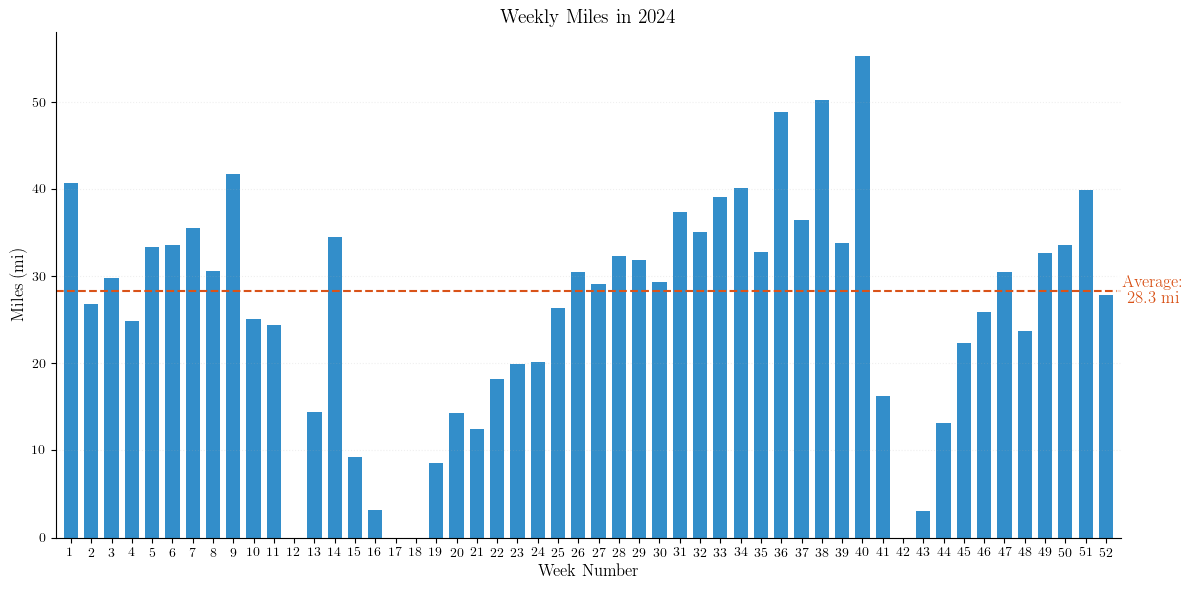

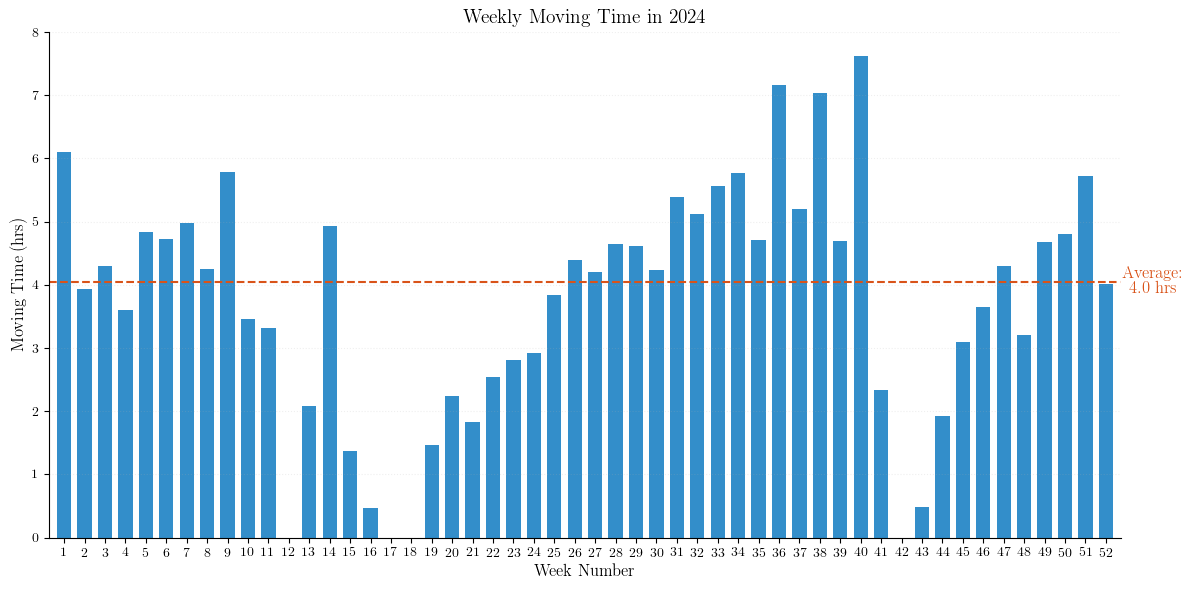

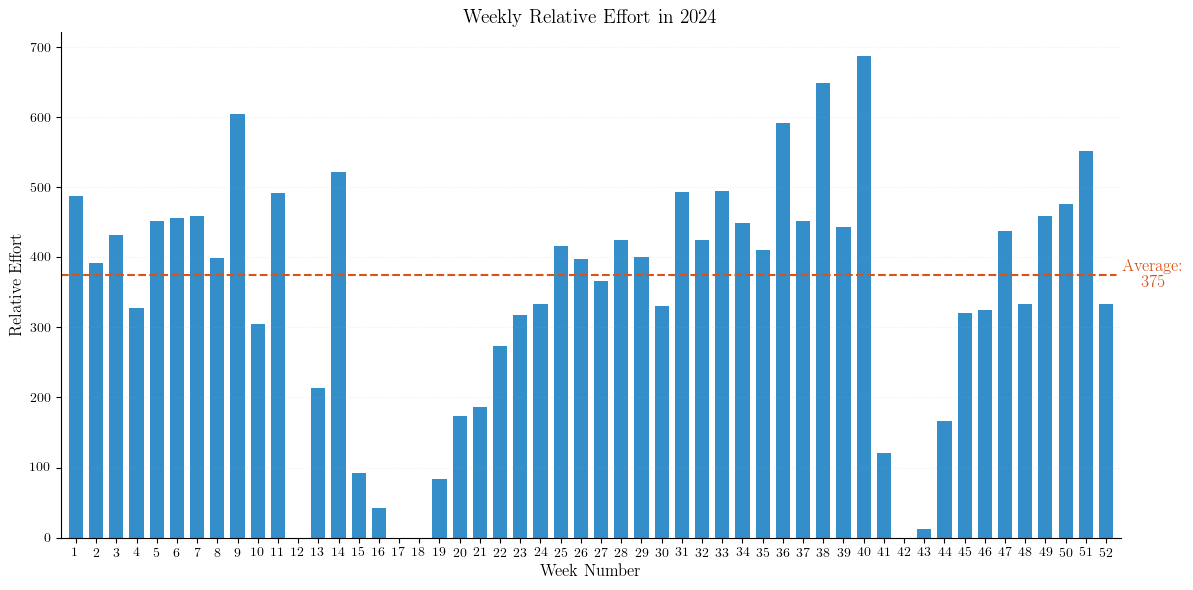

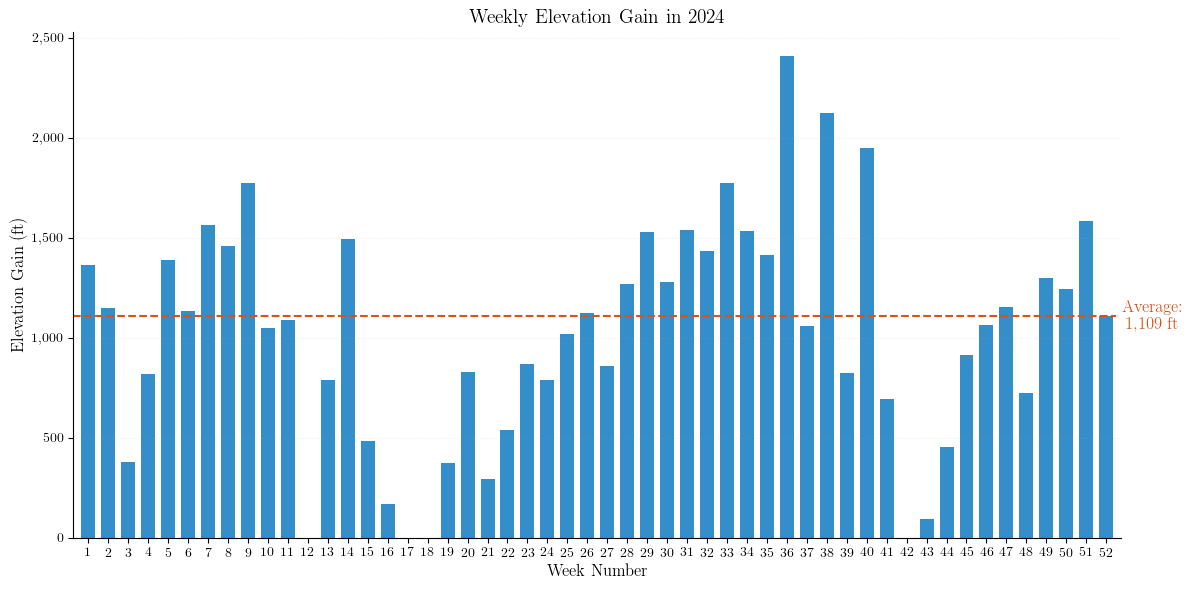

In [16]:
# function for plotting weekly totals for distance, time, elevation gain, and "suffer score" in a given year
def make_weekly_chart(year, var):

    # aggregate by week 
    grouped = runs[(runs['year'] == yr)].groupby('week_number')[var].sum().reset_index()
    group_mean = grouped[var].mean()

    # make graph
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.bar(grouped['week_number'], grouped[var], align = 'center', width = 0.7, alpha = 0.8, color = matlab_colors[0], label = f"Weekly {chart_labels[var]}")
    ax.grid(axis = 'y', alpha = 0.2, linestyle = ':')
    ax.axhline(y = group_mean, color = matlab_colors[1], linestyle = '--', label = f"Average Weekly {chart_labels[var]}")

    # create label for weekly average over the full year
    ax.text(
        x = (max(grouped['week_number']) + 1) * 1.025,
        y = group_mean,
        s = f"Average: \n {group_mean:,.1f} {chart_units[var]}" if group_mean < 100 else f"Average: \n {group_mean:,.0f} {chart_units[var]}",
        color = matlab_colors[1],
        fontsize = 12,
        ha = 'center',
        va = 'center',
        bbox = dict(
            boxstyle = 'round, pad = 0.3',
            facecolor = 'white',
            edgecolor = 'white',
            alpha = 0.8)
    )

    ax.set_title(f"Weekly {chart_labels[var]} in {yr}", fontsize = 14)
    ax.set_xlabel('Week Number', fontsize = 12)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_ylabel(f"{chart_labels[var]} ({chart_units[var]})" if chart_units[var] != '' else chart_labels[var], fontsize = 12)
    ax.set_xticks(range(1, max(grouped['week_number']) + 1))
    ax.tick_params(axis = 'both', labelsize = 10)
    ax.set_xlim(0.25, max(grouped['week_number']) + 0.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"weekly_{var}_{str(yr)}.pdf")

    return fig, ax

# set year
yr = 2024

# define chart labels and units
chart_labels = {
    'miles': 'Miles',
    'moving_time': 'Moving Time',
    'suffer_score': 'Relative Effort',
    'total_elevation_gain': 'Elevation Gain'
}

chart_units = {
    'miles': 'mi',
    'moving_time': 'hrs',
    'suffer_score': '',
    'total_elevation_gain': 'ft'
}

for var in chart_labels.keys():
    fig, ax = make_weekly_chart(year = yr, var = var)



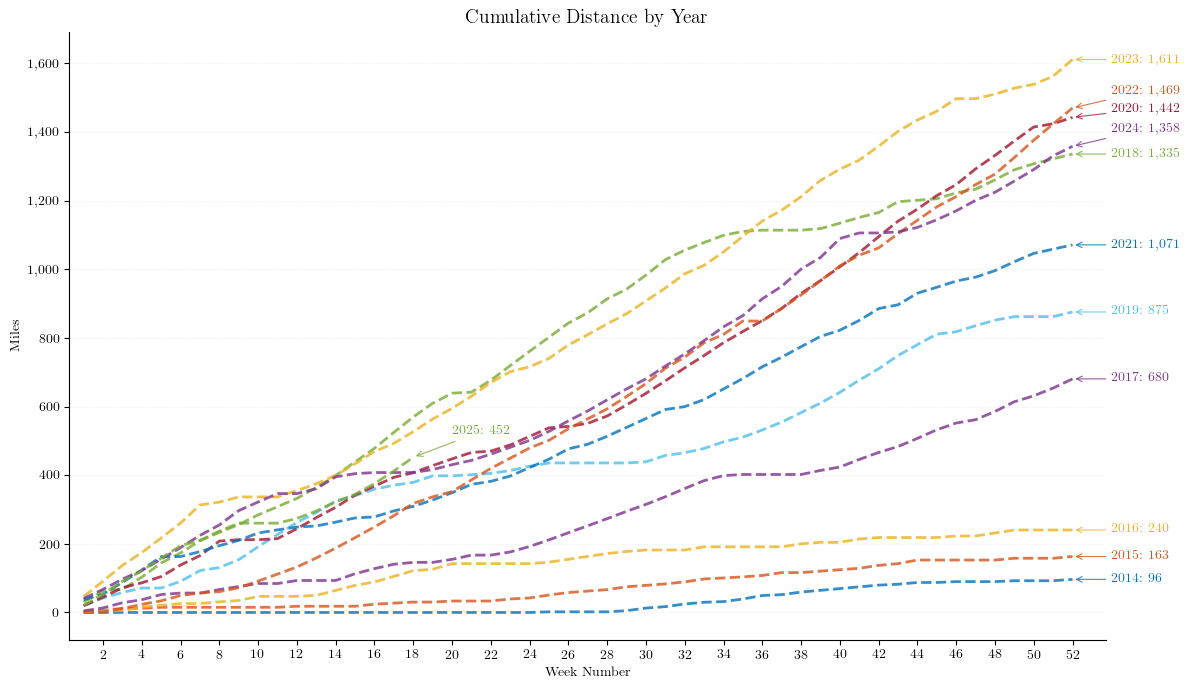

In [17]:
# plot cumulative mileage by year

# hard-coded vertical offsets to make the labels line up nicely...
y_offset = {
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 25,
    2021: 0,
    2022: 50,
    2023: 0,
    2024: 50,
    2025: 75
}

fig, ax = plt.subplots(figsize = (12, 7))
start, end = 2014, 2025
texts = []
for yr in range(start, end + 1):
    grouped = runs[(runs['year'] == yr)].groupby('week_number')[['miles']].sum() # sum miles by week for given year
    max_week = grouped.index.max() if yr == datetime.now().year else 53
    grouped = grouped.reindex(range(1, max_week), fill_value = 0) # fill in missing weeks with 0 mileage
    grouped['cumulative_miles'] = grouped['miles'].cumsum()
    total = float(grouped['cumulative_miles'].iloc[-1])
    ax.plot(grouped.index, grouped['cumulative_miles'], color = matlab_colors[(yr - start) % len(matlab_colors)], label = f"{yr}", linestyle = '--', linewidth = 2, alpha = 0.8)
    
    # last point on each line and corresponding label location
    x_final = grouped.index.max()
    y_final = grouped['cumulative_miles'].iloc[-1]
    label_x = x_final + 2
    label_y = y_final + y_offset.get(yr, 0)

    ax.annotate(
        text = f"{yr}: {int(total):,}",
        xy = (x_final, y_final), # point location
        xytext = (label_x, label_y), # label location
        textcoords = 'data',
        arrowprops = dict(
            arrowstyle = '->',
            color = matlab_colors[(yr - start) % len(matlab_colors)],
            linewidth = 0.8,
            alpha = 0.8,
            shrinkA = 2, shrinkB = 2
        ),
        ha = 'left',
        va = 'center',
        fontsize = 10,
        color = matlab_colors[(yr - start) % len(matlab_colors)]
    )

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.grid(axis = 'y', alpha = 0.2, linestyle = ':')
ax.set_title('Cumulative Distance by Year', fontsize = 14)
ax.set_xlabel('Week Number')
ax.set_ylabel('Miles')
ax.set_xticks(range(0, 53, 2))
ax.set_xlim(0.25, 53 + 0.75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('cumulative_distance_by_year.pdf')


In [ ]:
# calculate times spent in pace/heart rate zones by week
yr = 2024

# filter by year and aggregate time spent in each pace zone in each week
df_filtered = pace_zones_df[pace_zones_df['year'] == yr][['year', 'week_number', 'pace_zone_label', 'pace_zone_number', 'pace_zone_time', 'name']].drop_duplicates()
grouped = (df_filtered
    .groupby(['year', 'week_number', 'pace_zone_label', 'pace_zone_number', 'name'])
    .agg(time = ('pace_zone_time', 'sum'))
    .reset_index()
    .sort_values(by = ['year', 'week_number', 'pace_zone_number'])
)
grouped['time'] = grouped['time'] / 3600 # convert from seconds to hours

# pivot data
pivot_df = (grouped[(grouped['year'] == yr)]
    .pivot_table(
        index = 'week_number', 
        columns = 'pace_zone_number', 
        values = 'time', 
        aggfunc = 'sum', 
        fill_value = 0
    )
)
max_week = max(pivot_df.index.to_list())
pivot_df = pivot_df.reindex(range(1, max_week + 1), fill_value = 0) # fill in 0s

# plot
ax = pivot_df.plot(kind = 'bar', stacked = True, figsize = (12, 7), color = matlab_colors[:len(pivot_df.columns)], alpha = 0.8)
ax.set_title(f'Weekly Moving Time in Pace Zones in {yr}', fontsize = 14)
ax.set_xlabel('Week Number', fontsize = 12)
ax.set_ylabel('Total Time (hrs)', fontsize = 12)
ax.legend(title = 'Pace Zone', loc = 'upper left', fontsize = 12, title_fontsize = 12, frameon = False, ncol = 2, bbox_to_anchor = (1.0, 1.0))
ax.grid(axis = 'y', alpha = 0.2, linestyle = ':')
ax.tick_params(axis = 'both', labelsize = 10)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig(f"weekly_pace_zones_{yr}.pdf")

# filter by year and aggregate time spent in each pace zone in each week
df_filtered = heartrate_zones_df[heartrate_zones_df['year'] == yr][['year', 'week_number', 'heartrate_zone_label', 'heartrate_zone_number', 'heartrate_zone_time', 'name']].drop_duplicates()
grouped = (df_filtered
    .groupby(['year', 'week_number', 'heartrate_zone_label', 'heartrate_zone_number', 'name'])
    .agg(time = ('heartrate_zone_time', 'sum'))
    .reset_index()
    .sort_values(by = ['year', 'week_number', 'heartrate_zone_number'])
)
grouped['time'] = grouped['time'] / 3600 # convert from seconds to hours

pivot_df = (grouped[(grouped['year'] == yr)]
    .pivot_table(
        index = 'week_number', 
        columns = 'heartrate_zone_number', 
        values = 'time', 
        aggfunc = 'sum', 
        fill_value = 0
    )
)
max_week = max(pivot_df.index.to_list())
pivot_df = pivot_df.reindex(range(1, max_week + 1), fill_value = 0)

ax = pivot_df.plot(kind = 'bar', stacked = True, figsize = (12, 7), color = matlab_colors[:len(pivot_df.columns)], alpha = 0.8)
ax.set_title(f'Weekly Moving Time in Heart Rate Zones in {yr}', fontsize = 14)
ax.set_xlabel('Week Number', fontsize = 12)
ax.set_ylabel('Total Time (hrs)', fontsize = 12)
ax.legend(title = 'Heart Rate Zone', loc = 'upper left', fontsize = 12, title_fontsize = 12, frameon = False, ncol = 2, bbox_to_anchor = (1.0, 1.0))
ax.grid(axis = 'y', alpha = 0.2, linestyle = ':')
ax.tick_params(axis = 'both', labelsize = 10)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig(f"weekly_heartrate_zones_{yr}.pdf")



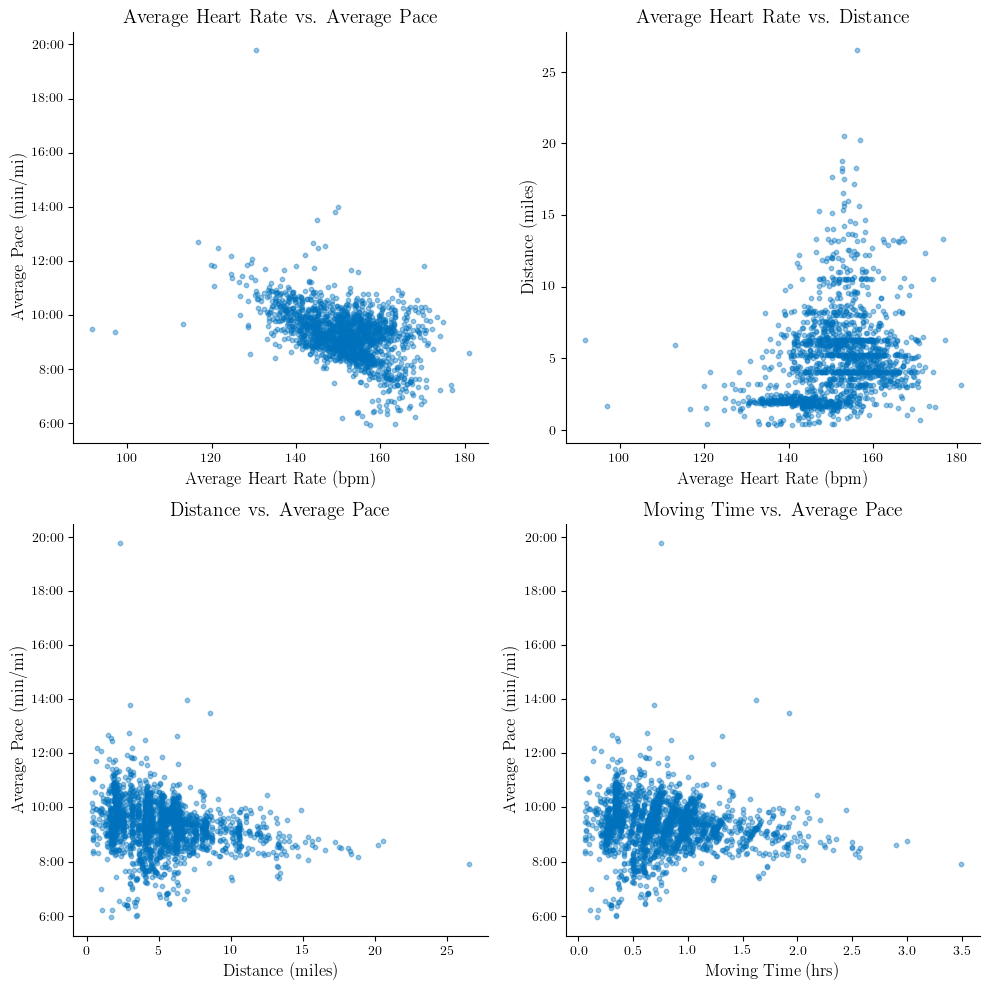

In [12]:
# function for formatting axis when plotting pace
def min_to_hms(time, pos):
    total_seconds = int(round(time * 60))
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60

    if hours > 0:
        return f"{hours}:{minutes:02d}"
    else:
        return f"{minutes:02d}:{seconds:02d}" if minutes >= 10 else f"{minutes:01d}:{seconds:02d}"


# make scatterplots
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10), sharex = False, sharey = False)

# heart rate vs. pace
ax[0, 0].scatter(runs['average_heartrate'], runs['average_pace'], color = matlab_colors[0], alpha = 0.4, s = 10)
ax[0, 0].set_title('Average Heart Rate vs. Average Pace', fontsize = 14)
ax[0, 0].set_xlabel('Average Heart Rate (bpm)', fontsize = 12)
ax[0, 0].set_ylabel('Average Pace (min/mi)', fontsize = 12)
ax[0, 0].tick_params(axis = 'both', labelsize = 10)
ax[0, 0].spines[['top', 'right']].set_visible(False)
ax[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(min_to_hms))

# heart rate vs. distance
ax[0, 1].scatter(runs['average_heartrate'], runs['miles'], color = matlab_colors[0], alpha = 0.4, s = 10)
ax[0, 1].set_title('Average Heart Rate vs. Distance', fontsize = 14)
ax[0, 1].set_xlabel('Average Heart Rate (bpm)', fontsize = 12)
ax[0, 1].set_ylabel('Distance (miles)', fontsize = 12)
ax[0, 1].tick_params(axis = 'both', labelsize = 10)
ax[0, 1].spines[['top', 'right']].set_visible(False)

# distance vs. pace
ax[1, 0].scatter(runs['miles'], runs['average_pace'], color = matlab_colors[0], alpha = 0.4, s = 10)
ax[1, 0].set_title('Distance vs. Average Pace', fontsize = 14)
ax[1, 0].set_xlabel('Distance (miles)', fontsize = 12)
ax[1, 0].set_ylabel('Average Pace (min/mi)', fontsize = 12)
ax[1, 0].tick_params(axis = 'both', labelsize = 10)
ax[1, 0].spines[['top', 'right']].set_visible(False)
ax[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(min_to_hms))

# moving time vs. pace
ax[1, 1].scatter(runs['moving_time'], runs['average_pace'], color = matlab_colors[0], alpha = 0.4, s = 10)
ax[1, 1].set_title('Moving Time vs. Average Pace', fontsize = 14)
ax[1, 1].set_xlabel('Moving Time (hrs)', fontsize = 12)
ax[1, 1].set_ylabel('Average Pace (min/mi)', fontsize = 12)
ax[1, 1].tick_params(axis = 'both', labelsize = 10)
ax[1, 1].spines[['top', 'right']].set_visible(False)
ax[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(min_to_hms))


plt.tight_layout()
plt.savefig('scatterplots.pdf')


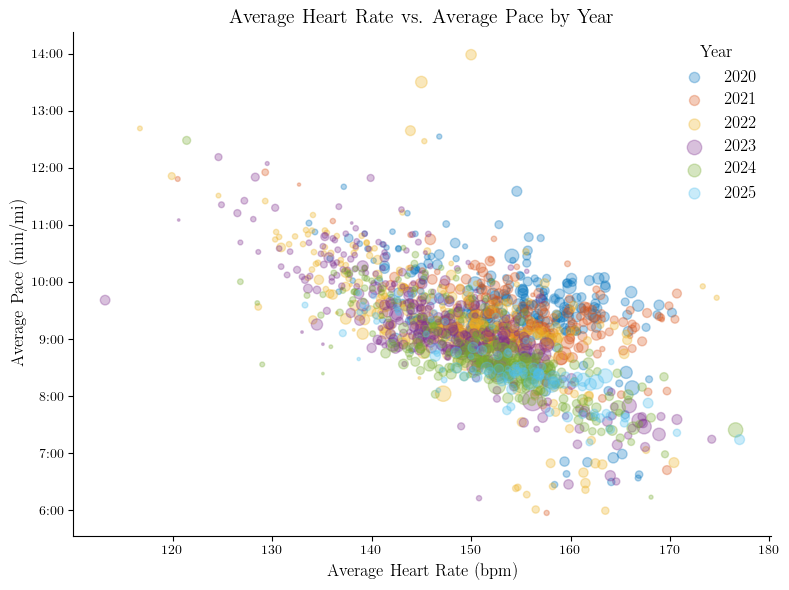

In [13]:
# scatterplot of heart rate vs. pace by year
fig, ax = plt.subplots(figsize = (8, 6))
start, end = 2020, 2026
for yr in range(start, end, 1):
    ax.scatter(
        runs[(runs['year'] == yr) & (runs['average_heartrate'] >= 100) & (runs['average_pace'] < 18)]['average_heartrate'], runs[(runs['year'] == yr) & (runs['average_heartrate'] >= 100) & (runs['average_pace'] < 18)]['average_pace'], # remove some outliers
        s = runs[(runs['year'] == yr) & (runs['average_heartrate'] >= 100) & (runs['average_pace'] < 18)]['distance'] * 0.005,
        color = matlab_colors[(yr - start) % len(matlab_colors)],
        alpha = 0.3,
        label = f"{yr}"
    )
ax.set_title('Average Heart Rate vs. Average Pace by Year', fontsize = 14)
ax.set_xlabel('Average Heart Rate (bpm)', fontsize = 12)
ax.set_ylabel('Average Pace (min/mi)', fontsize = 12)
ax.legend(
    title = 'Year',
    loc = 'upper right', 
    fontsize = 12,
    title_fontsize = 12,
    frameon = False,
    ncol = 1
)
ax.tick_params(axis = 'both', labelsize = 10)
ax.spines[['top', 'right']].set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(min_to_hms))

plt.tight_layout()
plt.savefig('heartrate_vs_pace_by_year.pdf')


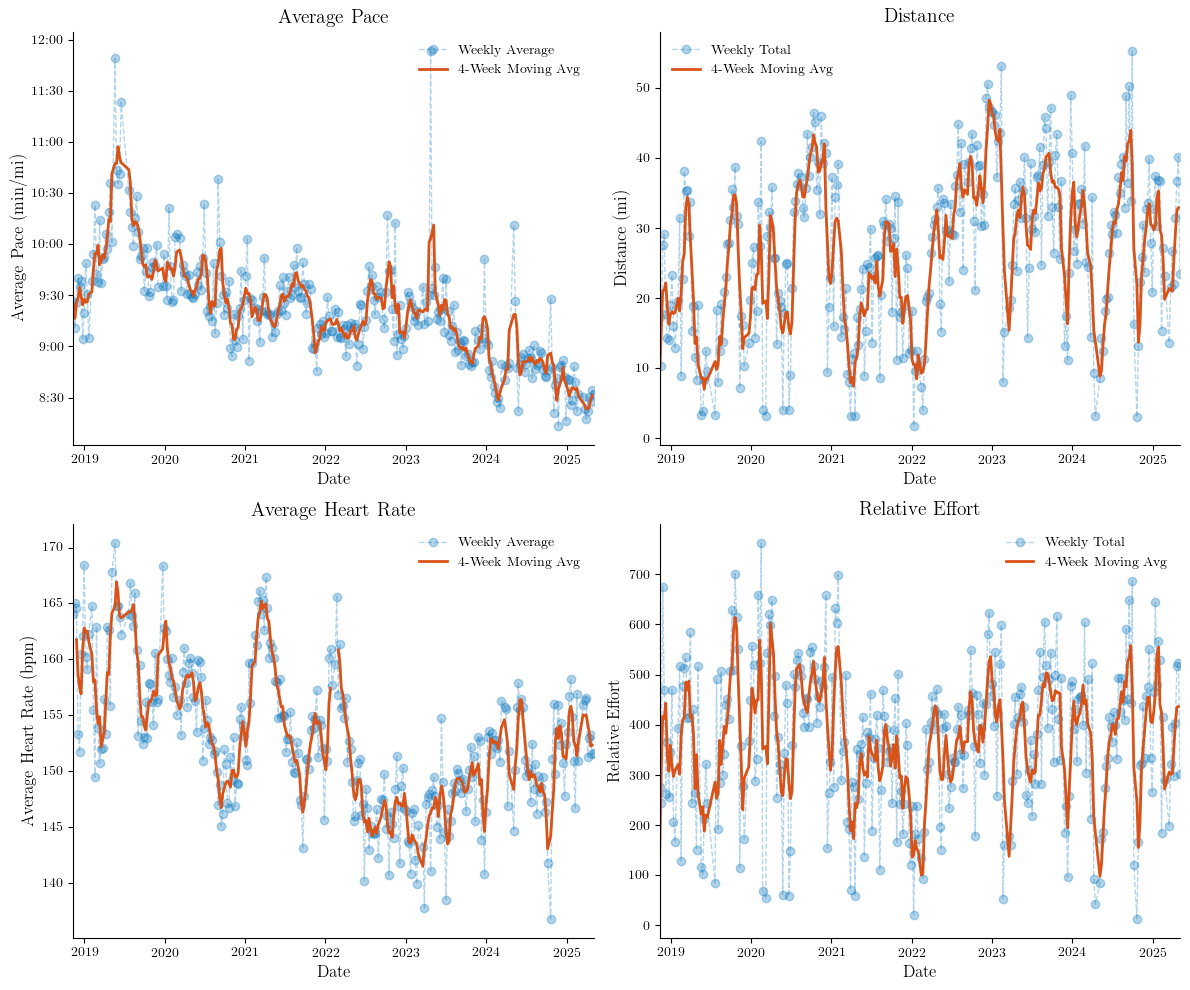

In [14]:
# time series
grouped = (runs
    .groupby(['year', 'week_number'])
    .agg(average_pace = ('average_pace', 'mean'), miles = ('miles', 'sum'), average_heartrate = ('average_heartrate', 'mean'), suffer_score = ('suffer_score', 'sum'))
    .reset_index()
)
grouped['year_week'] = grouped['year'].astype(str) + '-W' + grouped['week_number'].astype(str) # create year-week variable
grouped['date'] = pd.to_datetime(grouped['year_week'] + '-1', format = '%G-W%V-%u')
grouped = grouped.sort_values(by = 'date') # sort
 
# compute rolling averages
window = 4
grouped['average_pace_ma'] = grouped['average_pace'].rolling(window = window, center = True).mean()
grouped['miles_ma'] = grouped['miles'].rolling(window = window, center = True).mean()
grouped['suffer_score_ma'] = grouped['suffer_score'].rolling(window = window, center = True).mean()
grouped['average_heartrate_ma'] = grouped['average_heartrate'].rolling(window = window, center = True).mean()

# filter out activities for which HR data are not available (the pre-Garmin days!)
grouped = grouped[(grouped['average_heartrate'].notna())]

# make plot
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 10), sharex = False, sharey = False)

# average pace
ax[0, 0].plot(grouped['date'], grouped['average_pace'], color = matlab_colors[0], alpha = 0.3, marker = 'o', linewidth = 1, linestyle = '--', label = 'Weekly Average')
ax[0, 0].plot(grouped['date'], grouped['average_pace_ma'], color = matlab_colors[1], linewidth = 2, label = f"{window}-Week Moving Avg")
ax[0, 0].set_title('Average Pace', fontsize = 14)
ax[0, 0].set_xlim(grouped['date'].min(), grouped['date'].max())
ax[0, 0].set_xlabel('Date', fontsize = 12)
ax[0, 0].set_ylabel('Average Pace (min/mi)', fontsize = 12)
ax[0, 0].legend(loc = 'upper right', fontsize = 10, frameon = False)
ax[0, 0].tick_params(axis = 'both', labelsize = 10)
ax[0, 0].spines[['top', 'right']].set_visible(False)
ax[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(min_to_hms))

# weekly mileage
ax[0, 1].plot(grouped['date'], grouped['miles'], color = matlab_colors[0], alpha = 0.3, marker = 'o', linewidth = 1, linestyle = '--', label = 'Weekly Total')
ax[0, 1].plot(grouped['date'], grouped['miles_ma'], color = matlab_colors[1], linewidth = 2, label = f"{window}-Week Moving Avg")
ax[0, 1].set_title('Distance', fontsize = 14)
ax[0, 1].set_xlim(grouped['date'].min(), grouped['date'].max())
ax[0, 1].set_xlabel('Date', fontsize = 12)
ax[0, 1].set_ylabel('Distance (mi)', fontsize = 12)
ax[0, 1].legend(loc = 'upper left', fontsize = 10, frameon = False)
ax[0, 1].tick_params(axis = 'both', labelsize = 10)
ax[0, 1].spines[['top', 'right']].set_visible(False)

# average heart rate
ax[1, 0].plot(grouped['date'], grouped['average_heartrate'], color = matlab_colors[0], alpha = 0.3, marker = 'o', linewidth = 1, linestyle = '--', label = 'Weekly Average')
ax[1, 0].plot(grouped['date'], grouped['average_heartrate_ma'], color = matlab_colors[1], linewidth = 2, label = f"{window}-Week Moving Avg")
ax[1, 0].set_title('Average Heart Rate', fontsize = 14)
ax[1, 0].set_xlim(grouped['date'].min(), grouped['date'].max())
ax[1, 0].set_xlabel('Date', fontsize = 12)
ax[1, 0].set_ylabel('Average Heart Rate (bpm)', fontsize = 12)
ax[1, 0].legend(loc = 'upper right', fontsize = 10, frameon = False)
ax[1, 0].tick_params(axis = 'both', labelsize = 10)
ax[1, 0].spines[['top', 'right']].set_visible(False)

# weekly relative effort
ax[1, 1].plot(grouped['date'], grouped['suffer_score'], color = matlab_colors[0], alpha = 0.3, marker = 'o', linewidth = 1, linestyle = '--', label = 'Weekly Total')
ax[1, 1].plot(grouped['date'], grouped['suffer_score_ma'], color = matlab_colors[1], linewidth = 2, label = f"{window}-Week Moving Avg")
ax[1, 1].set_title('Relative Effort', fontsize = 14)
ax[1, 1].set_xlim(grouped['date'].min(), grouped['date'].max())
ax[1, 1].set_xlabel('Date', fontsize = 12)
ax[1, 1].set_ylabel('Relative Effort', fontsize = 12)
ax[1, 1].legend(loc = 'upper right', fontsize = 10, frameon = False)
ax[1, 1].tick_params(axis = 'both', labelsize = 10)
ax[1, 1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('timeseries.pdf')
